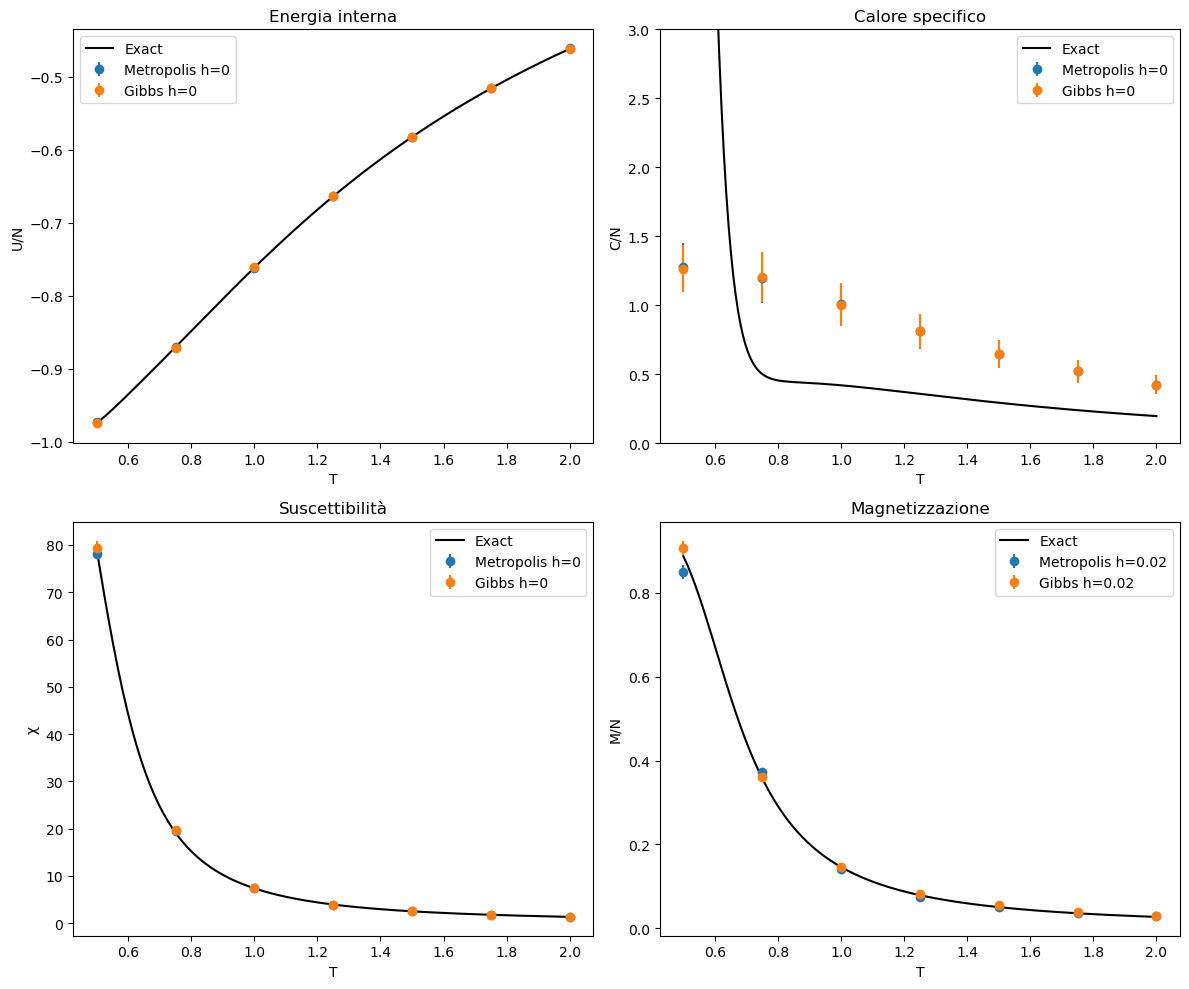

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Parametri ---
temps = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
N = 50
J = 1.0
kB = 1.0

# --- Funzioni analitiche ---
def internal_energy(T):
    beta = 1/T
    th = np.tanh(beta*J)
    thN = th**N
    return -J * th * (1 + th**(N-2))/(1 + thN)

def specific_heat(T):
    beta = 1/T
    th = np.tanh(beta*J)
    thN = th**N
    term1 = 1+thN+(N-1)*th**2+(N-1)*(th**(N-2))/(1+thN)
    term2 = N*((th+th**(N-1))/(1+thN))**2
    return (beta*J)**2 * (term1 - term2)

def susceptibility(T):
    beta = 1/T
    th = np.tanh(beta*J)
    thN = th**N
    return beta * np.exp(2*beta*J) * (1-thN)/(1+thN)

def magnetization(T, h=0.02):
    beta = 1/T
    l1 = np.exp(beta*J)*np.cosh(beta*h)+np.sqrt(np.exp(2*beta*J)*np.cosh(beta*h)**2-2*np.sinh(2*beta*J))
    l2 = np.exp(beta*J)*np.cosh(beta*h)-np.sqrt(np.exp(2*beta*J)*np.cosh(beta*h)**2-2*np.sinh(2*beta*J))
    Z = l1**N + l2**N
    num = (np.exp(beta*J)*np.sinh(beta*h)*
          (l1**(N-1)*(1+np.exp(beta*J)*np.cosh(beta*h)/np.sqrt(np.exp(2*beta*J)*np.cosh(beta*h)**2-2*np.sinh(2*beta*J))) +
           l2**(N-1)*(1-np.exp(beta*J)*np.cosh(beta*h)/np.sqrt(np.exp(2*beta*J)*np.cosh(beta*h)**2-2*np.sinh(2*beta*J)))))
    return num/Z

# --- Funzione per leggere dati numerici ---
def read_last_value(path, filename, cols=(2,3)):
    file_path = os.path.join(path, filename)
    if not os.path.exists(file_path):
        return None, None
    data = np.loadtxt(file_path)
    return data[-1, cols[0]], data[-1, cols[1]]

def collect_data(base_dir, algo, hlabel, obs_file, magnetization=False):
    vals, errs = [], []
    for T in temps:
        folder = os.path.join(base_dir, algo, hlabel, f"T{T}")
        fname = "magnetization.dat" if magnetization else obs_file
        v, e = read_last_value(folder, fname, cols=(2,3))
        vals.append(v)
        errs.append(e)
    return np.array(vals), np.array(errs)

# --- Raccolta dati ---
base = "."

# Energia interna
en_MC_h0, err_en_MC_h0 = collect_data(base, "Metropolis", "h0", "total_energy.dat")
en_GB_h0, err_en_GB_h0 = collect_data(base, "Gibbs", "h0", "total_energy.dat")

# Calore specifico
cv_MC_h0, err_cv_MC_h0 = collect_data(base, "Metropolis", "h0", "specific_heat.dat")
cv_GB_h0, err_cv_GB_h0 = collect_data(base, "Gibbs", "h0", "specific_heat.dat")

# Suscettibilità
chi_MC_h0, err_chi_MC_h0 = collect_data(base, "Metropolis", "h0", "susceptibility.dat")
chi_GB_h0, err_chi_GB_h0 = collect_data(base, "Gibbs", "h0", "susceptibility.dat")

# Magnetizzazione (solo h=0.02)
mag_MC_h002, err_mag_MC_h002 = collect_data(base, "Metropolis", "h002", "magnetization.dat", magnetization=True)
mag_GB_h002, err_mag_GB_h002 = collect_data(base, "Gibbs", "h002", "magnetization.dat", magnetization=True)

# --- Curve analitiche ---
Tfine = np.linspace(0.5, 2.0, 200)
U_exact = [internal_energy(T) for T in Tfine]
C_exact = [specific_heat(T) for T in Tfine]
X_exact = [susceptibility(T) for T in Tfine]
M_exact = [magnetization(T, h=0.02) for T in Tfine]

# --- Plot ---
plt.figure(figsize=(12,10))

# Energia interna
plt.subplot(2,2,1)
plt.errorbar(temps, en_MC_h0, yerr=err_en_MC_h0, fmt='o', label="Metropolis h=0")
plt.errorbar(temps, en_GB_h0, yerr=err_en_GB_h0, fmt='o', label="Gibbs h=0")
plt.plot(Tfine, U_exact, 'k-', label="Exact")
plt.xlabel("T"); plt.ylabel("U/N"); plt.legend(); plt.title("Energia interna")

# Calore specifico
plt.subplot(2,2,2)
plt.errorbar(temps, cv_MC_h0, yerr=err_cv_MC_h0, fmt='o', label="Metropolis h=0")
plt.errorbar(temps, cv_GB_h0, yerr=err_cv_GB_h0, fmt='o', label="Gibbs h=0")
plt.plot(Tfine, C_exact, 'k-', label="Exact")
plt.xlabel("T"); plt.ylabel("C/N"); plt.legend(); plt.title("Calore specifico")
plt.ylim(0, 3)  #limiti dell'asse y 

# Suscettibilità
plt.subplot(2,2,3)
plt.errorbar(temps, chi_MC_h0, yerr=err_chi_MC_h0, fmt='o', label="Metropolis h=0")
plt.errorbar(temps, chi_GB_h0, yerr=err_chi_GB_h0, fmt='o', label="Gibbs h=0")
plt.plot(Tfine, X_exact, 'k-', label="Exact")
plt.xlabel("T"); plt.ylabel("χ"); plt.legend(); plt.title("Suscettibilità")

# Magnetizzazione
plt.subplot(2,2,4)
plt.errorbar(temps, mag_MC_h002, yerr=err_mag_MC_h002, fmt='o', label="Metropolis h=0.02")
plt.errorbar(temps, mag_GB_h002, yerr=err_mag_GB_h002, fmt='o', label="Gibbs h=0.02")
plt.plot(Tfine, M_exact, 'k-', label="Exact")
plt.xlabel("T"); plt.ylabel("M/N"); plt.legend(); plt.title("Magnetizzazione")

plt.tight_layout()
plt.show()
